In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV


import warnings
from sklearn.impute import SimpleImputer
from sklearn import svm, linear_model, datasets, mixture
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (confusion_matrix, precision_score, recall_score,
                             accuracy_score, roc_auc_score, RocCurveDisplay)

from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler

from xgboost import plot_importance

In [39]:
df = pd.read_table("healthcare-dataset-stroke-data.csv",sep=",")
dummies = df.join(pd.get_dummies(df[["gender", "ever_married", "work_type", "Residence_type","smoking_status"]]))

In [40]:
X = dummies.loc[:, dummies.columns != "stroke"]
y = dummies["stroke"]

In [41]:
#zero imputation
dummies["bmi_na"] = dummies["bmi"].isna()
imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=None)
dummies.bmi = imp.fit_transform(dummies.bmi.to_numpy().reshape(-1, 1))
dummies

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,...,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,bmi_na
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,...,1,0,0,0,1,0,1,0,0,False
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,0.0,...,0,1,0,1,0,0,0,1,0,True
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,...,1,0,0,1,0,0,0,1,0,False
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,...,1,0,0,0,1,0,0,0,1,False
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,...,0,1,0,1,0,0,0,1,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,0.0,...,1,0,0,0,1,0,0,1,0,True
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,...,0,1,0,0,1,0,0,1,0,False
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,...,0,1,0,1,0,0,0,1,0,False
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,...,1,0,0,1,0,0,1,0,0,False


In [42]:
keyz = [2,3,4,8,9,14,24,26,28]
gender = [12,13]
married = [15,16]
work = [17,18,19,20,21]
resid = [22,23]
        
dummies["bmi_na"] = dummies["bmi"].isna()
imp = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=None)
dummies.bmi = imp.fit_transform(dummies.bmi.to_numpy().reshape(-1, 1))
        
for var in [gender, married, work, resid]:
    keyz.extend(random.sample(var,len(var)-1))   
X = dummies[dummies.keys()[keyz]]

In [43]:
# split 80% training data, 20% "_tmp" for validation & test
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2,
                                                  random_state=0, stratify=y)
        # of remaining 20%, split in half to get 10% validation, 10% test
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,
                                                  random_state=0, stratify=y_tmp)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [45]:
warnings.filterwarnings(action='ignore')
parameters = [{'n_estimators':(10,25,50,100), 'learning_rate':[0.01, 0.1, 0.25, 0.5, 1], 'max_depth': [1,2,5,10]}]
clf = GridSearchCV(GradientBoostingClassifier(), parameters,scoring="recall")
clf.fit(X_resampled, y_resampled)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid=[{'learning_rate': [0.01, 0.1, 0.25, 0.5, 1],
                          'max_depth': [1, 2, 5, 10],
                          'n_estimators': (10, 25, 50, 100)}],
             scoring='recall')

In [46]:
clf.best_params_

{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 50}

In [32]:
clf.best_score_

1.0

precision=0.151, recall=0.32, accuracy=0.879, auc=0.64


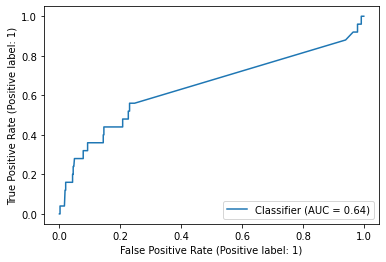

In [33]:
y_pred = clf.predict(X_test)
precision = precision_score(y_true=y_test, y_pred=y_pred)
recall = recall_score(y_true=y_test, y_pred=y_pred)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
probability_y_is_1 = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_true=y_test, y_score=probability_y_is_1)
print(f'precision={precision:.3}, recall={recall:.3}, accuracy={accuracy:.3}, auc={auc:.3}')
probability_y_is_1 = clf.predict_proba(X_test)[:, 1]
RocCurveDisplay.from_predictions(y_true=y_test, y_pred=probability_y_is_1)
plt.show(block=False)

precision=0.0, recall=0.0, accuracy=0.951, auc=0.5


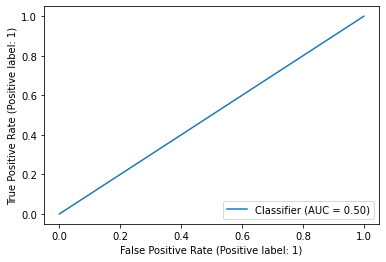

In [12]:
zeros = np.zeros(len(y_test))
precision = precision_score(y_true=y_test, y_pred=zeros)
recall = recall_score(y_true=y_test, y_pred=zeros)
accuracy = accuracy_score(y_true=y_test, y_pred=zeros)
probability_y_is_1 = zeros
auc = roc_auc_score(y_true=y_test, y_score=zeros)
print(f'precision={precision:.3}, recall={recall:.3}, accuracy={accuracy:.3}, auc={auc:.3}')
probability_y_is_1 = clf.predict_proba(X_test)[:, 1]
RocCurveDisplay.from_predictions(y_true=y_test, y_pred=zeros)
plt.show(block=False)

In [13]:
#mean imputation
X = dummies.loc[:, dummies.columns != "stroke"]

keyz = [2,3,4,8,9,14,24,26,28]
gender = [12,13]
married = [15,16]
work = [17,18,19,20,21]
resid = [22,23]
        
dummies["bmi_na"] = dummies["bmi"].isna()
imp = SimpleImputer(missing_values=np.nan, strategy="mean", fill_value=None)
dummies.bmi = imp.fit_transform(dummies.bmi.to_numpy().reshape(-1, 1))   

for var in [gender, married, work, resid]:
    keyz.extend(random.sample(var,len(var)-1))   
X = dummies[dummies.keys()[keyz]]

# split 80% training data, 20% "_tmp" for validation & test
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2,
                                                  random_state=0, stratify=y)
        # of remaining 20%, split in half to get 10% validation, 10% test
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,
                                                  random_state=0, stratify=y_tmp)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

clf = GridSearchCV(GradientBoostingClassifier(), parameters,scoring="recall")
clf.fit(X_resampled, y_resampled)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid=[{'learning_rate': [0.01, 0.1, 0.25],
                          'max_depth': [1, 2, 3],
                          'n_estimators': (10, 25, 50, 100)}],
             scoring='recall')

precision=0.116, recall=0.32, accuracy=0.847, auc=0.72


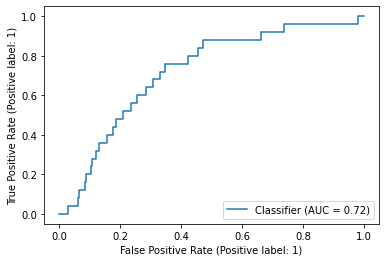

In [14]:
y_pred = clf.predict(X_test)

recall = recall_score(y_true=y_test, y_pred=y_pred)

probability_y_is_1 = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_true=y_test, y_score=probability_y_is_1)
print(f'precision={precision:.3}, recall={recall:.3}, accuracy={accuracy:.3}, auc={auc:.3}')
probability_y_is_1 = clf.predict_proba(X_test)[:, 1]
RocCurveDisplay.from_predictions(y_true=y_test, y_pred=probability_y_is_1)
plt.show(block=False)

In [15]:
M = confusion_matrix(y_true=y_test, y_pred=y_pred)
df = pd.DataFrame(data=M)
print(f'df:\n{df}')

df:
     0   1
0  425  61
1   17   8


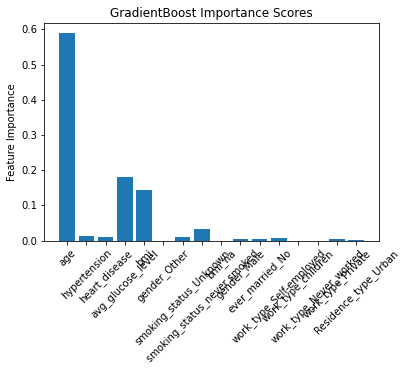

In [16]:
clf = GradientBoostingClassifier(learning_rate=0.25, max_depth=3, n_estimators=150)
clf.fit(X_resampled, y_resampled)
importance = dict({"Keys":X_train.keys(), "Score":clf.feature_importances_})
plt.bar(importance["Keys"] , importance["Score"])
plt.xticks(rotation = 45)
plt.title("GradientBoost Importance Scores")
plt.ylabel("Feature Importance")
plt.show()

In [17]:
X_train.keys()

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'gender_Other', 'smoking_status_Unknown', 'smoking_status_never smoked',
       'bmi_na', 'gender_Male', 'ever_married_No', 'work_type_Self-employed',
       'work_type_children', 'work_type_Never_worked', 'work_type_Private',
       'Residence_type_Urban'],
      dtype='object')

In [18]:
importance

{'Keys': Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
        'gender_Other', 'smoking_status_Unknown', 'smoking_status_never smoked',
        'bmi_na', 'gender_Male', 'ever_married_No', 'work_type_Self-employed',
        'work_type_children', 'work_type_Never_worked', 'work_type_Private',
        'Residence_type_Urban'],
       dtype='object'),
 'Score': array([0.58842868, 0.0136505 , 0.00967682, 0.18024618, 0.14240669,
        0.        , 0.00927234, 0.03224496, 0.        , 0.00473897,
        0.00493423, 0.008517  , 0.        , 0.        , 0.00483092,
        0.00105272])}

In [38]:
# split 80% training data, 20% "_tmp" for validation & test
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2,
                                                  random_state=0, stratify=y)
        # of remaining 20%, split in half to get 10% validation, 10% test
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,
                                                  random_state=0, stratify=y_tmp)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

parameters = {'C':np.linspace(0, 1, 101)}
svc = linear_model.LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True, max_iter=1000)
clf = GridSearchCV(svc, parameters, scoring = 'recall')
clf.fit(X_resampled, y_resampled)
print("Logistic Regression:")
print(f'Accuracy Score ={clf.score(X_test, y_test):.3}, ' +
      f'clf.best_params_={clf.best_params_}')

Logistic Regression:
Accuracy Score =0.72, clf.best_params_={'C': 0.36}


In [20]:
# split 80% training data, 20% "_tmp" for validation & test
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2,
                                                  random_state=0, stratify=y)
        # of remaining 20%, split in half to get 10% validation, 10% test
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,
                                                  random_state=0, stratify=y_tmp)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

[[ 0.07633168  0.58700604  0.40204471  0.00521105 -0.0331756   0.
  -0.31544532 -0.24721389  0.          0.10092928 -0.16065339  0.
  -0.14761417  0.          0.50307377 -0.09053988]]
recall=0.72, auc=0.824, 0.7690802348336595, 0.13953488372093023


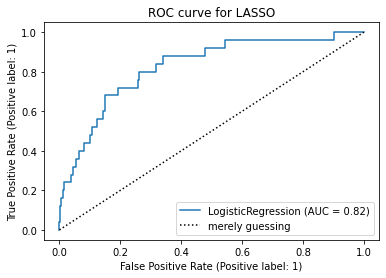

In [37]:
LR = linear_model.LogisticRegression(C=.26, penalty='l1', solver='liblinear', fit_intercept=True, max_iter=1000)
LR.fit(X_resampled, y_resampled)
y_hat = LR.predict(X_test)
precision = precision_score(y_true=y_test, y_pred=y_hat)
accuracy = accuracy_score(y_true=y_test, y_pred=y_hat)
recall = recall_score(y_true=y_test, y_pred=y_hat)
probability_y_is_1 = LR.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_true=y_test, y_score=probability_y_is_1)

print(LR.coef_)

print(f'recall={recall:.3}, auc={auc:.3}, {accuracy}, {precision}')

RocCurveDisplay.from_estimator(LR, X_test, y_test)
plt.plot([0, 1], [0, 1], ':k', label='merely guessing')
plt.title('ROC curve for LASSO')
plt.legend()
plt.show()